In [43]:
%pip install networkx matplotlib

  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached matplotlib-3.10.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp312-cp312-macosx_10_13_universal2.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached numpy-2.3.5-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pillow-12.0.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached networkx-3.6.1-py3-none-any.whl (2.1 MB)
Using cached matplotlib-3.10.8-cp312-cp312-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp312-cp312-macosx_11_0_arm64.whl (273 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp312-cp312-macosx_10_

In [1]:
import random

Create Environment

In [2]:
STATES = ["START", "VOLCANO", "BASE", "SITE_A", "SITE_B", "IMMOBILE"]
ACTIONS = ["LEFT", "RIGHT"]

TERMINAL_STATES = {"BASE", "IMMOBILE", "DESTROYED"}

In [3]:
# MARKOV DECISION PROCESS
MDP = {
    "START": {
        "LEFT": [
            {"prob": 0.9, "next_state": "SITE_A", "reward": -1},
            {"prob": 0.1, "next_state": "IMMOBILE", "reward": -3},
        ],
        "RIGHT": [
            {"prob": 0.5, "next_state": "BASE", "reward": 10},
            {"prob": 0.5, "next_state": "DESTROYED", "reward": -10},
        ],
    },

    "SITE_A": {
        "LEFT": [
            {"prob": 1.0, "next_state": "START", "reward": -1},
        ],
        "RIGHT": [
            {"prob": 0.8, "next_state": "SITE_B", "reward": -1},
            {"prob": 0.2, "next_state": "IMMOBILE", "reward": -3},
        ]
    },

    "SITE_B": {
        "LEFT": [
            {"prob": 1.0, "next_state": "SITE_A", "reward": -1},
        ],
        "RIGHT": [
            {"prob": 1.0, "next_state": "BASE", "reward": 10},
        ]
    },

    # Terminal states (no actions)
    "BASE": {},
    "IMMOBILE": {},
    "DESTROYED": {},
}


In [4]:
TERMINAL_STATES = {s for s, a in MDP.items() if len(a) == 0}
ALL_STATES = list(MDP.keys())


In [5]:
def reset_env():
    state = "START"
    done = False
    return state, done


Game play - function to transition states in enviornment

In [6]:
def step_env(state, action):
    if state in TERMINAL_STATES:
        raise ValueError("Episode has terminated. Call reset_env().")

    if action not in MDP[state]:
        raise ValueError(f"Invalid action '{action}' for state '{state}'")

    outcomes = MDP[state][action]

    r = random.random()
    cumulative = 0.0

    for outcome in outcomes:
        cumulative += outcome["prob"]
        if r <= cumulative:
            next_state = outcome["next_state"]
            reward = outcome["reward"]
            done = next_state in TERMINAL_STATES
            return next_state, reward, done

    # Safety fallback (floating-point issues)
    last = outcomes[-1]
    next_state = last["next_state"]
    reward = last["reward"]
    done = next_state in TERMINAL_STATES
    return next_state, reward, done


Run An episode - apply the policy function to the environment and see the outcome

In [7]:
def run_episode(policy_fn):
    state, done = reset_env()
    total_reward = 0
    trajectory = []

    while not done:
        action = policy_fn(state)
        next_state, reward, done = step_env(state, action)

        trajectory.append((state, action, reward, next_state))
        total_reward += reward
        state = next_state

    return trajectory, total_reward



Create the polices

#this is a 'policy' where the rover looks at all states and determines the optimal path
#there is no reinforcement learning, jsut a straight calculation
#this becomes the greedy policy


In [8]:
def initialize_values():
    return {state: 0.0 for state in MDP}

In [9]:
def value_iteration(mdp, gamma=0.95, theta=1e-6):
    V = initialize_values()

    while True:
        delta = 0

        for state, actions in mdp.items():

            # Skip terminal states
            if not actions:
                continue

            best_value = float("-inf")

            for action, outcomes in actions.items():
                action_value = 0

                for o in outcomes:
                    prob = o["prob"]
                    reward = o["reward"]
                    next_state = o["next_state"]

                    action_value += prob * (reward + gamma * V[next_state])

                best_value = max(best_value, action_value)

            delta = max(delta, abs(V[state] - best_value))
            V[state] = best_value

        if delta < theta:
            break

    return V


In [10]:
def extract_optimal_policy(mdp, V, gamma=0.95):
    policy = {}

    for state, actions in mdp.items():
        if not actions:
            continue

        best_action = None
        best_value = float("-inf")

        for action, outcomes in actions.items():
            action_value = 0

            for o in outcomes:
                action_value += o["prob"] * (
                    o["reward"] + gamma * V[o["next_state"]]
                )

            if action_value > best_value:
                best_value = action_value
                best_action = action

        policy[state] = best_action

    return policy


In [11]:
GAMMA = 0.95   # how much the rover values future rewards

V_star = value_iteration(MDP, GAMMA)
optimal_policy = extract_optimal_policy(MDP, V_star, GAMMA)

print("Optimal Value Function:")
for s, v in V_star.items():
    print(f"{s:10s}: {v:.3f}")

print("\nOptimal Policy:")
for s, a in optimal_policy.items():
    print(f"{s:10s} -> {a}")

Optimal Value Function:
START     : 4.101
SITE_A    : 6.200
SITE_B    : 10.000
BASE      : 0.000
IMMOBILE  : 0.000
DESTROYED : 0.000

Optimal Policy:
START      -> LEFT
SITE_A     -> RIGHT
SITE_B     -> RIGHT


Create deterministic policy based on table above
This is not RL

In [13]:
def greedy_policy(state):
    if state == "START":
        return "LEFT"
    if state in ["SITE_A", "SITE_B"]:
        return "RIGHT"
    raise ValueError("No action available")

Create the one step look ahead policy

In [14]:
def one_step_lookahead_policy(state):
    actions = MDP[state]

    if not actions:
        raise ValueError(f"No actions available from terminal state {state}")

    best_action = None
    best_ev = float("-inf")

    for action, outcomes in actions.items():
        ev = 0.0
        for o in outcomes:
            ev += o["prob"] * o["reward"]

        if ev > best_ev:
            best_ev = ev
            best_action = action

    return best_action


Create 100% random policy

In [15]:
def random_policy(state):
    actions = list(MDP[state].keys())
    return random.choice(actions)


Create RL Policy by running 10000 times and seeing the results of each action
Then chaning the path based on past results

In [16]:
Q = {}

for state, actions in MDP.items():
    for action in actions:
        Q[(state, action)] = 0.0


In [17]:
alpha = 0.1      # learning rate
gamma = 0.95     # future reward importance
epsilon = 0.1    # exploration probability

In [18]:
def epsilon_greedy_policy(state):
    actions = list(MDP[state].keys())

    if random.random() < epsilon:
        return random.choice(actions)  # explore

    return max(actions, key=lambda a: Q[(state, a)])  # exploit


In [19]:
def train_q_learning(episodes=10_000):
    for _ in range(episodes):
        state, done = reset_env()

        while not done:
            action = epsilon_greedy_policy(state)
            next_state, reward, done = step_env(state, action)

            if next_state in MDP and MDP[next_state]:
                future = max(Q[(next_state, a)] for a in MDP[next_state])
            else:
                future = 0  # terminal state

            Q[(state, action)] += alpha * (
                reward + gamma * future - Q[(state, action)]
            )

            state = next_state


In [20]:
train_q_learning()

In [21]:
def learned_policy(state):
    actions = list(MDP[state].keys())
    return max(actions, key=lambda a: Q[(state, a)])


Run Policys one time

In [22]:
trajectory, total_reward = run_episode(greedy_policy)

for step in trajectory:
    print(step)

print("Total reward:", total_reward)


('START', 'LEFT', -1, 'SITE_A')
('SITE_A', 'RIGHT', -1, 'SITE_B')
('SITE_B', 'RIGHT', 10, 'BASE')
Total reward: 8


In [34]:
trajectory, total_reward = run_episode(one_step_lookahead_policy)

print("Trajectory:")
for step in trajectory:
    print(step)

print("Total reward:", total_reward)

Trajectory:
('START', 'RIGHT', 10, 'BASE')
Total reward: 10


In [24]:
trajectory, total_reward = run_episode(learned_policy)

print("Trajectory:")
for step in trajectory:
    print(step)

print("Total reward:", total_reward)

Trajectory:
('START', 'LEFT', -1, 'SITE_A')
('SITE_A', 'RIGHT', -1, 'SITE_B')
('SITE_B', 'RIGHT', 10, 'BASE')
Total reward: 8


In [54]:
trajectory, total_reward = run_episode(random_policy)

print("Trajectory:")
for step in trajectory:
    print(step)

print("Total reward:", total_reward)

Trajectory:
('START', 'LEFT', -1, 'SITE_A')
('SITE_A', 'RIGHT', -1, 'SITE_B')
('SITE_B', 'LEFT', -1, 'SITE_A')
('SITE_A', 'RIGHT', -1, 'SITE_B')
('SITE_B', 'RIGHT', 10, 'BASE')
Total reward: 6


Run policies 10,000 times (Monte Carlo)

In [41]:
def evaluate_policy(policy_fn, episodes=10000):
    rewards = []
    for _ in range(episodes):
        _, total = run_episode(policy_fn)
        rewards.append(total)
    return sum(rewards) / len(rewards)


In [39]:
print("Greedy policy avg reward:", evaluate_policy(greedy_policy))
print("Random policy avg reward:", evaluate_policy(random_policy))
print("One step lookahead policy avg reward:", evaluate_policy(one_step_lookahead_policy))
print("Learned policy avg reward:", evaluate_policy(one_step_lookahead_policy))


Greedy policy avg reward: 4.744
Random policy avg reward: 0.241
One step lookahead policy avg reward: -0.4
Learned policy avg reward: -0.22


Print out the network graph because I love graphs

In [44]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_mdp_graph(MDP):
    G = nx.DiGraph()

    for state, actions in MDP.items():
        if not actions:  # terminal state
            G.add_node(state)
            continue

        for action, outcomes in actions.items():
            for o in outcomes:
                label = f"{action}\nP={o['prob']}, R={o['reward']}"
                G.add_edge(state, o["next_state"], label=label)

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(14, 10))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=2800,
        node_color="lightgray",
        font_size=10,
        arrows=True
    )

    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Mars Rover MDP")
    plt.show()


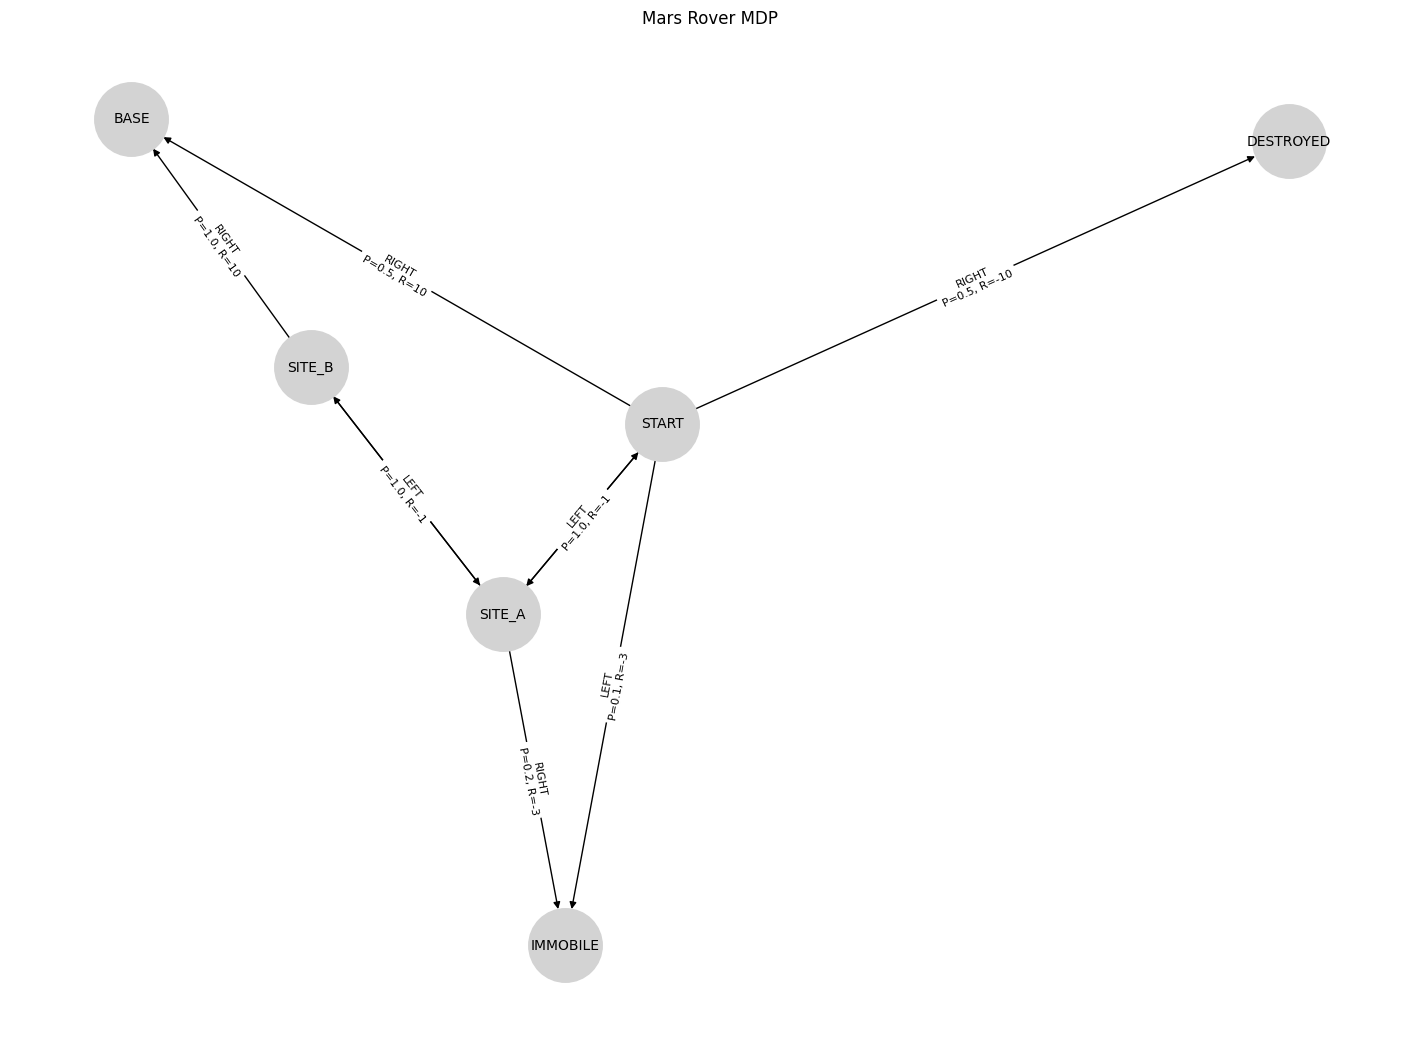

In [45]:
plot_mdp_graph(MDP)